In [1]:
%load_ext rpy2.ipython

Protocol used by Albertas to make this data: https://benchling.com/anavickas/f/lib_VNejBHt6-protocols/prt_2Bkfh557-meripseq/edit

HIV-1 IIIB Virus


https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607

We are starting from `fastq` files as raw data: 

In [13]:
%%R
list.files('fastq')

 [1] "01_IN_23_NT_S3_L002_R1_001.fastq.gz"         
 [2] "01_IN_23_NT_S3_L002_trim.fastq.gz"           
 [3] "02_IN_23_METTL3_S4_L002_R1_001.fastq.gz"     
 [4] "02_IN_23_METTL3_S4_L002_trim.fastq.gz"       
 [5] "03_IN_23_METTL14_S5_L002_R1_001.fastq.gz"    
 [6] "03_IN_23_METTL14_S5_L002_trim.fastq.gz"      
 [7] "04_IN_23_Virma_S6_L002_R1_001.fastq.gz"      
 [8] "04_IN_23_Virma_S6_L002_trim.fastq.gz"        
 [9] "05_IN_23_WTAP_S7_L002_R1_001.fastq.gz"       
[10] "05_IN_23_WTAP_S7_L002_trim.fastq.gz"         
[11] "06_IN_24_NT_S8_L002_R1_001.fastq.gz"         
[12] "06_IN_24_NT_S8_L002_trim.fastq.gz"           
[13] "07_IN_24_METTL3_S9_L002_R1_001.fastq.gz"     
[14] "07_IN_24_METTL3_S9_L002_trim.fastq.gz"       
[15] "08_IN_24_METTL14_S10_L002_R1_001.fastq.gz"   
[16] "08_IN_24_METTL14_S10_L002_trim.fastq.gz"     
[17] "09_IN_24_Virma_S11_L002_R1_001.fastq.gz"     
[18] "09_IN_24_Virma_S11_L002_trim.fastq.gz"       
[19] "10_IN_24_WTAP_S12_L002_R1_001.fastq.gz"      
[20] "10_IN_

## Trimming 

In [ ]:
%%bash 
cd ~/People/Judd/fastq
for f in *_L002_R1_001.fastq.gz; do  
    out=${f/\_S[1-9]*/.trim.fastq.gz}; 
    cutadapt -j 12 -q 15 -m 20 -a NNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o ../trim/$out $f; 
done

## Alignment

Unmmaped reads for each `fastq` file saved for later alignment to HIV genome 

Human genome: `gencode.v28.annotation.gtf`

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
for f in trim/*.fastq.gz;do
    out=${f/.trim.fastq.gz/_};
    out=${out/trim/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/

HIV genome indices created by changing sequence provided by Judd to `.fa` format

In [ ]:
%%bash 
# make hiv genome indices 
bowtie2-build HIV/HIV.fa HIV/HIV
# Aligning to hiv genome 
for f in fastq_unmapped/*; do
	o=${f/.fastq/.bam};
 	o=${o/fastq_unmapped/bam};
 	bowtie2 --sensitive -N 1 -x HIV/HIV -U $f | samtools sort -o $o;
done

All `bam`  files (mapped to human genome or hiv genome) renamed in this format: 
> `<sample>.<species>.<treatment>.<input/m6A>.bam`

In [14]:
%%R
list.files('bam')

 [1] "s23.hiv.METTL14.input.bam"       "s23.hiv.METTL14.input.bam.bai"  
 [3] "s23.hiv.METTL14.m6A.bam"         "s23.hiv.METTL14.m6A.bam.bai"    
 [5] "s23.hiv.METTL3.input.bam"        "s23.hiv.METTL3.input.bam.bai"   
 [7] "s23.hiv.METTL3.m6A.bam"          "s23.hiv.METTL3.m6A.bam.bai"     
 [9] "s23.hiv.NT.input.bam"            "s23.hiv.NT.input.bam.bai"       
[11] "s23.hiv.NT.m6A.bam"              "s23.hiv.NT.m6A.bam.bai"         
[13] "s23.hiv.Virma.input.bam"         "s23.hiv.Virma.input.bam.bai"    
[15] "s23.hiv.Virma.m6A.bam"           "s23.hiv.Virma.m6A.bam.bai"      
[17] "s23.hiv.WTAP.input.bam"          "s23.hiv.WTAP.input.bam.bai"     
[19] "s23.hiv.WTAP.m6A.bam"            "s23.hiv.WTAP.m6A.bam.bai"       
[21] "s23.human.METTL14.input.bam"     "s23.human.METTL14.input.bam.bai"
[23] "s23.human.METTL14.m6A.bam"       "s23.human.METTL14.m6A.bam.bai"  
[25] "s23.human.METTL3.input.bam"      "s23.human.METTL3.input.bam.bai" 
[27] "s23.human.METTL3.m6A.bam"        "s23.human.M

# Peakcalling 

## Control

Comparing to RADAR package, exomepeak also claculate coverage for only non threted samples. We used different conda `environment` for exomepeak (and it takes long time to run!!). 

In [ ]:
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("/rumi/shams/abe/People/Judd/bam")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='human.NT.m6A.bam$'),
    INPUT_BAM=list.files(pattern='human.NT.input.bam$'),
    OUTPUT_DIR='../exomepeak',
    EXPERIMENT_NAME='control'
)
saveRDS(res, paste('../exomepeak','control', 'results.rds', sep='/'))

### Plot _Guitar_ 
Now, let's draw metagene plots for control samples:

In [5]:
library(Guitar)

In [3]:
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


In [4]:
GuitarPlot(txTxdb = txdb,stBedFiles = list("exomepeak/control/peak.bed"),miscOutFilePrefix = "control")

[1] "20200223050452"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200223050924"
[1] "import BED file exomepeak/control/peak.bed"
[1] "sample 10 points for Group1"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 2 out-of-bound ranges located on sequences
  ENST00000508832.2 and ENST00000583166.1. Note that ranges located on a
  sequence whose length is unknown (NA) or on a circular sequence are not
  considered out-of-bound (use seqlengths() and isCircular() to get the
  lengths and circularity flags of the underlying sequences). You can use
  trim() to trim these ranges. See ?`trim,GenomicRanges-method` for more
  information.”

[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


### Motif analysis 

In [ ]:
%%bash 
cd exomepeak/human/control/
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.bed -split -fo peak.fa
# prepare fasta file for FIRE
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks
# run FIRE --doskipdiscovery=1
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0
mv peaks_teiser.txt_FIRE/ motifs_of_interest_FIRE
# run FIRE --doskipdiscovery=0
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0

## Differential methylation

We are using RADAR package for meRIP data analysis ([see RADAR manual](https://scottzijiezhang.github.io/RADARmanual/workflow.html)). It will run over bam files for each enzyme treatment. `run_radar` function do it all for you :) 

In [2]:
library("RADAR")
run_radar <- function(enz, gtf,species='human', cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
    outputDir = paste("radar", species,enz, sep='/')
    radar <- countReads(
        samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
        gtf = gtf,
        bamFolder = "bam",
        modification = 'm6A',
        strandToKeep = "opposite",
        outputDir = outputDir,
        threads = threads,
        saveOutput = TRUE
    )
    saveRDS(radar, file = paste(outputDir,"raw.radar.rds",sep='/')) # ,compress = TRUE)
    radar <- normalizeLibrary(radar, boxPlot = FALSE)
    radar <- adjustExprLevel(radar)
    
    variable(radar) <- data.frame( Group =data.frame( Group = rep(c("Ctrl","Treated"),2)) )
    radar <- filterBins(radar,minCountsCutOff = 15)
    radar <- diffIP_parallel(radar, thread = threads)
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
    result <- results(radar)
    
    write.csv(results, paste(outputDir,'radar.bed',sep='/'), quote = FALSE, row.names = FALSE)
    saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/')) # ,compress = TRUE)
}

### Run radar on human bam files 

In [ ]:
# %%bash 
# # Declare a string array with type
# declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')

# # Read the array values with space
# for enz in "${StringArray[@]}"; do
#   echo "########################################################"
#   echo "Runing RADAR for "$enz
#   echo "########################################################"
#   Rscript _sh/radar.r $enz;

**radar.r** file contain: 

In [ ]:
# library("RADAR")
# args <- commandArgs(trailingOnly = TRUE)
# enz <- args[1]
# gtf <- args[2]

# run_radar <- function(enz, gtf,species='human', cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
#     outputDir = paste("radar", species,enz, sep='/')
#     radar <- countReads(
#         samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
#         gtf = gtf,
#         bamFolder = "bam",
#         modification = 'm6A',
#         strandToKeep = "opposite",
#         outputDir = outputDir,
#         threads = threads,
#         saveOutput = TRUE
#     )
#     saveRDS(radar, file = paste(outputDir,"raw.radar.rds",sep='/')) # ,compress = TRUE)
#     radar <- normalizeLibrary(radar, boxPlot = FALSE)
#     radar <- adjustExprLevel(radar)
    
#     variable(radar) <- data.frame( Group =data.frame( Group = rep(c("Ctrl","Treated"),2)) )
#     radar <- filterBins(radar,minCountsCutOff = 15)
#     radar <- diffIP_parallel(radar, thread = threads)
#     top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
#     radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
#     result <- results(radar)
    
#     # save plots 
#     pdf(paste("plots/radar.",enz,".Heatmap.pdf",sep=''), width=7, height=7, paper = "a4r")
#     plotHeatMap(radar,covariates = FALSE)
#     dev.off()

#     png(paste("plots/radar.",enz,".Heatmap.png",sep=''))
#     plotHeatMap(radar,covariates = FALSE)
#     dev.off()

#     p = peakDistribution(radar)
#     ggsave(paste("plots/radar.",enz,".Distribution.png",sep=''), plot = p, device = 'png', dpi = 300, width = 5, height = 5)
    
#     p = plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )
#     ggsave(paste("plots/radar.",enz,".PCA.png",sep=''), plot = p, device = 'png', dpi = 300, width = 8, height = 5)

    
#     write.csv(results, paste(outputDir,'radar.bed',sep='/'), quote = FALSE, row.names = FALSE)
#     saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/')) # ,compress = TRUE)
# }

# run_radar(enz,gtf)

Using `plotHeatMap`, `plotPCAfromMatrix` and `peakDistribution` function from RADAR package:

In [14]:
# for (enz in c('METTL14','METTL3','Virma','WTAP')){
#     radar = readRDS(paste('radar/human/',enz,'/radar.rds',sep=''))

#     pdf(paste("plots/radar.",enz,".Heatmap.pdf",sep=''), width=7, height=7, paper = "a4r")
#     plotHeatMap(radar,covariates = FALSE)
#     dev.off()

#     png(paste("plots/radar.",enz,".Heatmap.png",sep=''))
#     plotHeatMap(radar,covariates = FALSE)
#     dev.off()

#     p = peakDistribution(radar)
#     ggsave(paste("plots/radar.",enz,".Distribution.png",sep=''), plot = p, device = 'png', dpi = 300, width = 5, height = 5)
    
#     top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
#     p = plotPCAfromMatrix(top_bins,group = unlist(variable(radar)) )
#     ggsave(paste("plots/radar.",enz,".PCA.png",sep=''), plot = p, device = 'png', dpi = 300, width = 8, height = 5)
# }

In [ ]:
# cat radar.bed | awk -F, '{OFS=",";print $1,$2,$3,$4,"1",$6}' > radar.c.bed
# awk '{gsub(/\,/,"\t");print;}' radar.bed > radar.t.bed

# Running a custom pipeline 

Here we're using https://github.com/gold-lab/bed12ToGTF to make gtf file from control exomepeak result.

https://metacpan.org/pod/Bio::FeatureIO::gtf

In [ ]:
%%bash
cat exomepeak/control/peak.bed | perl ../../Workflows/bed12ToGTF/bed12ToGTF.1.pl > exomepeak/control/peak.gtf
cat exomepeak/control/peak.gtf | awk '{gsub(/\"|\;/,"")}1' | awk '{gsub(/transcript_id/,"gene_id")}1' > exomepeak/control/peak.edited.gtf

In [41]:
# gtf = "/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf"
gtf = "exomepeak/control/peak.gtf"

Using `featureCounts` to count reads which are present in control peak cordinates (found by `exomepeak`). 

In [ ]:
%%bash
declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
for enz in "${StringArray[@]}"; 
    do for f in bam/*human.$enz*.bam; 
        do out=${f/.bam/.fc}; out=${out/bam/peakcount}; 
        featureCounts -T 12 -P -B -C -O -t exon -g gene_id -a exomepeak/control/peak.edited.gtf -o $out $f; 
    done; 
done

using `DESeq2` to find differential methylation genes: 

In [1]:
%reload_ext rpy2.ipython

In [3]:
%%R
library(DESeq2)
library(tidyverse)
library(ggplot2)
library(patchwork)
pca = list(); vol = list(); hist = list()

In [4]:
%%R
all_dds = list()
for (treat in c('METTL14','METTL3','Virma','WTAP'
               )){
    files <- list.files(path = 'fc',pattern=paste(treat,".fc$",sep = ''))
    reps <- rep(c('s23','s24'),2)
    ip <- c(rep('input',2),rep('m6A',2))
    conds <- paste(treat,ip, sep='.')
    all_conds <- paste(reps,treat,ip, sep='.')
    datalist <- lapply(files, function(x){read.table(file=paste('fc/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
    m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
    rownames(m) <- paste ('human',m[,1],sep='-')
    m <- m[,-1]
    m[is.na(m)]<-0
    m <- round(m)
    colnames(m) <- all_conds
    colData <- data.frame(cond = conds, row.names=all_conds)
    dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref=paste(treat,".input",sep = ''))
    dds <- DESeq(dds)
    
    all_dds[[treat]] = dds
    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    res <- results(dds)
    write.table(res, paste('deseq/',treat,'_m6A_vs_input.txt',sep=''), sep="\t", quote=FALSE, col.names=NA)
    # Raw tabels 
    write.table(ncu, file=paste('deseq/',treat,'_gene_count_table_DE2norm.txt',sep=''), sep="\t", quote=FALSE, col.names=all_conds) 
    write.table(m, file=paste('deseq/',treat,'_gene_count_table_raw.txt',sep=''), sep="\t", quote=FALSE, col.names=all_conds)
}

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[wr

### Plots 

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.6

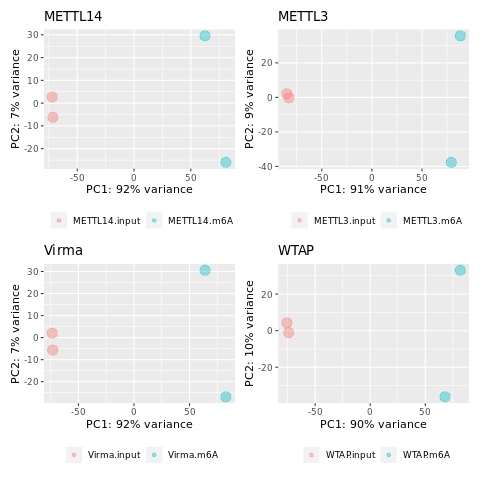

In [151]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    dds = all_dds[[treat]]
    res <- results(dds)    
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    ## PCA Plot 
    z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
    percentVar <- round(100 * attr(z, "percentVar"))
    pca[[treat]] <- ggplot(z, aes(PC1, PC2)) +
            ggtitle(treat) + 
            geom_point(aes(size = 2,  colour=cond), alpha = 4/10) +
            xlab(paste0("PC1: ",percentVar[1],"% variance")) +
            ylab(paste0("PC2: ",percentVar[2],"% variance")) +
            guides(size = FALSE) +
            theme(
                legend.title = element_blank(), 
                legend.position = "bottom"  )
}    
p = pca$METTL14 + pca$METTL3 + pca$Virma + pca$WTAP
ggsave("plots/all_PCAs.png", plot = p, device = 'png', dpi = 300)
ggsave("plots/all_PCAs.pdf", plot = p, device = 'pdf', dpi = 300)
p

R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



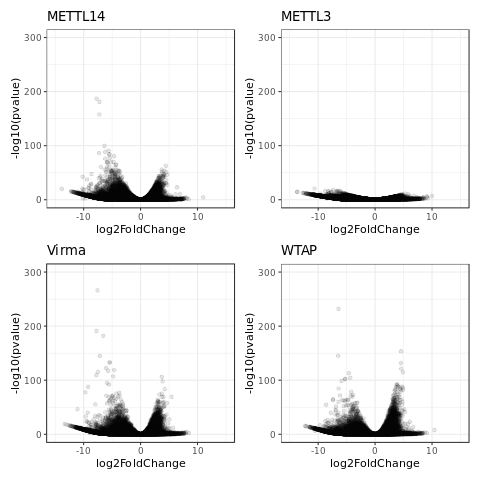

In [139]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    dds = all_dds[[treat]]
    res <- results(dds)    
    vol[[treat]] = data.frame(res) %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue))) +
            geom_point(alpha = 1/10) +
            ggtitle(treat) +
            xlim(c(-15,15)) +
            ylim(c(0,300)) +
            theme_bw() + 
            theme(legend.position="none")
}
v = vol$METTL14 + vol$METTL3 + vol$Virma + vol$WTAP
ggsave("plots/all_Volcanos.png", plot = v, device = 'png', dpi = 300)
ggsave("plots/all_Volcanos.pdf", plot = v, device = 'pdf', dpi = 300)
v

[Wilcoxon signed rank test](http://www.sthda.com/english/wiki/one-sample-wilcoxon-signed-rank-test-in-r)

[1] "METTL14"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 93036000, p-value < 2.2e-16
alternative hypothesis: true location is less than 0

[1] "METTL3"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 86635000, p-value < 2.2e-16
alternative hypothesis: true location is less than 0

[1] "Virma"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 85497000, p-value < 2.2e-16
alternative hypothesis: true location is less than 0

[1] "WTAP"

	Wilcoxon signed rank test with continuity correction

data:  res$log2FoldChange
V = 100430000, p-value < 2.2e-16
alternative hypothesis: true location is less than 0



R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



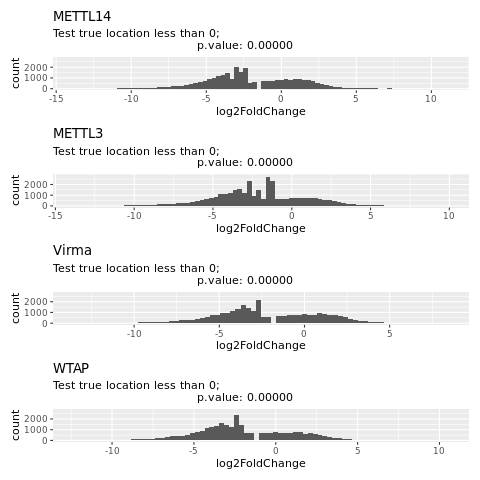

In [27]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    dds = all_dds[[treat]]
    res <- results(dds)    
    res = data.frame(res)
    d <- res$log2FoldChange[!is.na(res$log2FoldChange)]
    t <- wilcox.test(res$log2FoldChange,mu = 0, alternative = "less")
    
    print (treat)
    print (t)
    hist[[treat]] = ggplot(res, aes(x=log2FoldChange)) +
            ggtitle(treat, sprintf("Test true location less than 0;\
                                    p.value: %.5f", t$p.value)) +
            ylim(c(-10,2800)) +
            geom_histogram(binwidth=0.3)
}
h = hist$METTL14 / hist$METTL3 / hist$Virma / hist$WTAP
ggsave("plots/all_Histograms.png", plot = h, device = 'png', dpi = 300)
ggsave("plots/all_Histograms.pdf", plot = h, device = 'pdf', dpi = 300)
h

## Pairwise correlation of each treatments 
http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software

In [165]:
%%R
library(Hmisc)
library(corrplot)
library(pheatmap)

In [166]:
%%R
all_fc = data.frame(
    METTL14 = data.frame(results(all_dds$METTL14))$log2FoldChange,
    METTL3 = data.frame(results(all_dds$METTL3))$log2FoldChange,
    Virma = data.frame(results(all_dds$Virma))$log2FoldChange,
    WTAP = data.frame(results(all_dds$WTAP))$log2FoldChange,
    row.names = rownames(data.frame(results(all_dds[[1]])))
)
colSums(is.na(all_fc))

METTL14  METTL3   Virma    WTAP 
  22484   22481   22252   21905 


In [179]:
%%R
res2 <- rcorr(as.matrix(all_fc))
# # Extract the correlation coefficients
# res2$r
# # Extract p-values
# res2$P

pdf("plots/Corrplot.pdf", width=7, height=7)
corrplot(res2$r, type="upper", order="hclust", method="pie",
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
dev.off()
png("plots/Corrplot.png")
corrplot(res2$r, type="upper", order="hclust", method="pie",
         p.mat = res2$P, sig.level = 0.01, insig = "blank")
dev.off()

png 
  2 


R[write to console]: Saving 6.67 x 6.67 in image

R[write to console]: Saving 6.67 x 6.67 in image



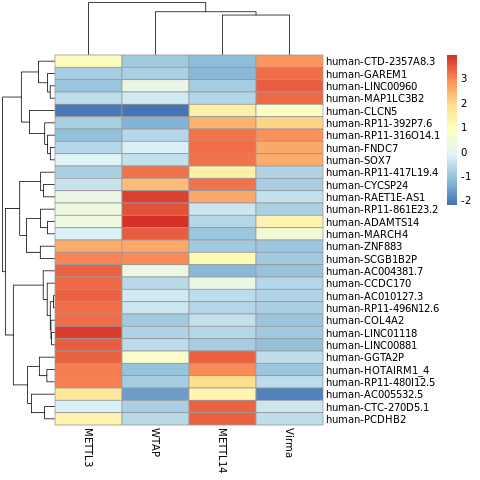

In [180]:
%%R
# mostVar Calculate the top n most variable genes in a matrix of gene expression data
# https://rdrr.io/github/abc-igmm/transcripTools/man/mostVar.html
mostVar <- function(data, n, i_want_most_var = TRUE) {
  data.var <- apply(data, 1, stats::var)
  data[order(data.var, decreasing = i_want_most_var)[1:n],] 
}

# scale - Z-Score
fc <- data.frame(apply(all_fc,2,scale, center=TRUE, scale=TRUE), row.names=rownames(all_fc))
# filter most variable genes
fc = mostVar(fc,30)
# Plot heatmap
h1 <- pheatmap(fc, show_rownames = T)
ggsave('plots/All_Heatmap.png', plot = h1, device = 'png', dpi = 300)
ggsave('plots/All_Heatmap.pdf', plot = h1, device = 'pdf', dpi = 300)

# Run piranha for HIV bam files 

In [ ]:
%%bash
### m6A bam files ###
# Merge .bam files:
samtools merge -@ 12 piranha/hiv.m6A.bam bam/*hiv*m6A.bam
# sort the merged file >>> it's not making any change
samtools sort -@12 piranha/hiv.m6A.bam > piranha/hiv.m6A.srt.bam
# bam to bed
bedtools bamtobed -i piranha/hiv.m6A.srt.bam > piranha/hiv.m6A.srt.bed

### input bam files ###
# Merge .bam files:
samtools merge -@ 12 piranha/hiv.input.bam bam/*hiv*input.bam
# sort the merged file >>> it's not making any change
samtools sort -@12 piranha/hiv.input.bam > piranha/hiv.input.srt.bam
# bam to bet
bedtools bamtobed -i piranha/hiv.input.srt.bam > piranha/hiv.input.srt.bed

### run Piranha ###
Piranha -s -i 50 piranha/hiv.m6A.srt.bed piranha/hiv.input.srt.bed -o piranha/hiv.piranha.txt
# make new ref file
awk '{printf("%s\t%d\t%d\t%d\t1\t%s\n",$1,$2,$3, NR,$4)}' piranha/hiv.piranha.txt > piranha/final_piranha.bed
awk '{printf("%s\t%s\t%d\t%d\t%s\n",$4,$1,$2+1,$3,$6)}' piranha/final_piranha.bed > piranha/final_piranha.saf
### first line of piranha/final_piranha.saf removed manually 

In [ ]:
%%bash
# make new reletive counts
for f in bam/*hiv*.m6A.bam; do
    out=${f/.bam/.piranha.fc};
    out=${out/bam/piranha\/fc};
    echo featureCounts -T 12 -O -F SAF -a piranha/final_piranha.saf -o $out $f;
done

for f in bam/*hiv*.input.bam; do
    out=${f/.bam/.piranha.fc};
    out=${out/bam/piranha\/fc};
    echo featureCounts -T 12 -O -F SAF -a piranha/final_piranha.saf -o $out $f;
done

In [2]:
%reload_ext rpy2.ipython

In [4]:
%%R
library(DESeq2)
library(ggplot2)
library(tidyverse)
library(pheatmap)

In [6]:
%%R
files <- list.files(path = "piranha/fc", pattern="fc$") 
reps <- c(rep('s23',10),rep('s24',10))
ip <- rep(c('input','m6A'),10)
enzymes <- rep(unlist(lapply(c('METTL14','METTL3','NT','Virma','WTAP'), rep, 2)),2)
conds <- ip
all_conds <- paste(
    reps,
    enzymes, 
    ip, 
    sep='.')
datalist <- lapply(files, function(x){read.table(file=paste('piranha/fc/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- paste ('hiv',m[,1],sep='-')
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- all_conds
colData <- data.frame(cond = conds, row.names=colnames(m))

comparing m6A/input for each knockdown to control


In [194]:
%%bash
mkdir bigwig/METTL14
mkdir bigwig/METTL3
mkdir bigwig/Virma
mkdir bigwig/WTAP

mkdir bedgraph/METTL14
mkdir bedgraph/METTL3
mkdir bedgraph/Virma
mkdir bedgraph/WTAP

In [18]:
%%R
options(repr.plot.width=4, repr.plot.height=4)
all_vsd = list()
for (enz in c('METTL14','METTL3','Virma','WTAP')){
    icond = c(grep(enz,all_conds), grep('NT',all_conds) )
    mm <- m[,icond]
    colData <- data.frame(cond= conds[icond], row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref='input')
    dds <- DESeq(dds)
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    # Plot heatmap
    vsd_mat <- assay(vsd)
    all_vsd[[enz]] = data.frame(vsd_mat)
    
    # save scales to normalize peak visulization with GViz 
    dds <- estimateSizeFactors(dds)
    scale_df <- data.frame('scale' = 1/sizeFactors(dds))
    write.table(scale_df, paste("bigwig/",enz,"/scale.txt", sep=''), sep="\t", quote=FALSE, col.names=NA)
#     # normalized counts 
#     ncu <- counts(dds, normalized=TRUE)
#     # Raw tabels 
#     write.table(ncu, file=paste("piranha/results/",enz,".hiv.","gene_count_table_DE2norm.txt", sep=''), sep="\t", quote=FALSE, col.names=colnames(mm)) 
#     write.table(mm, file=paste("piranha/results/",enz,".hiv.","gene_count_table_raw.txt", sep=''), sep="\t", quote=FALSE, col.names=colnames(mm))
#     # model:
#     res <- results(dds)
#     write.table(res, paste("piranha/results/",enz,".hiv.","input_vs_m6A.txt", sep=''), sep="\t", quote=FALSE, col.names=NA)
}

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: found already estimated dispersions, replacing these

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: converting counts to integer mode

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to conso

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


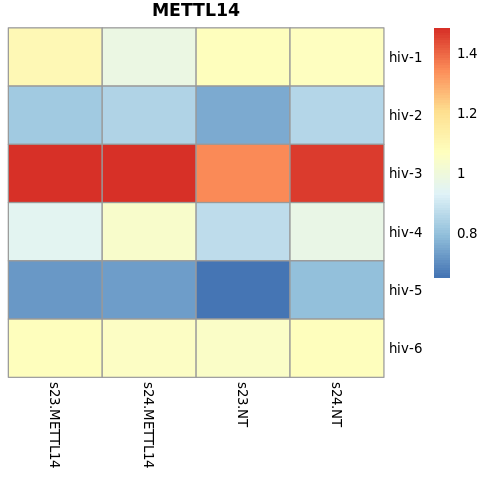

Saving 6.67 x 6.67 in image


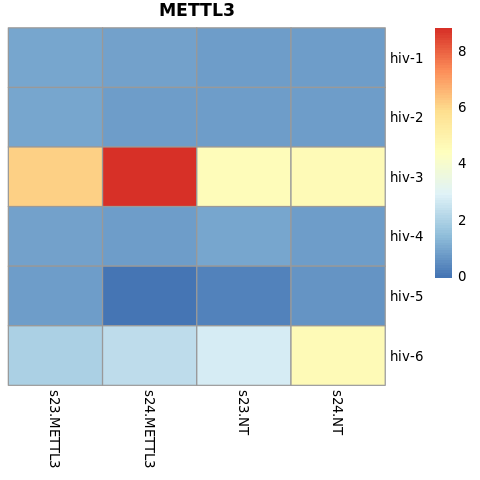

Saving 6.67 x 6.67 in image


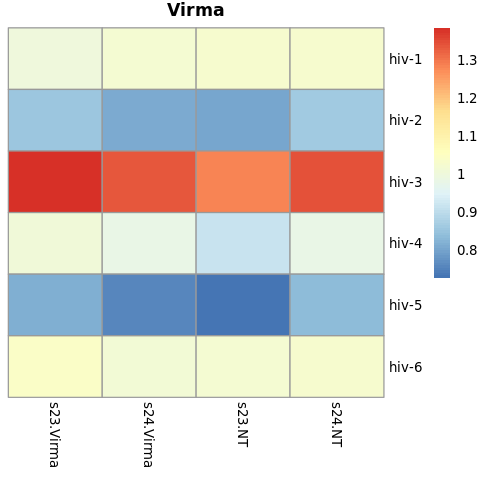

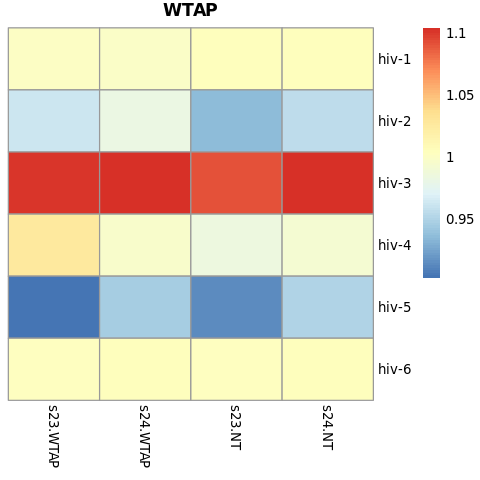

In [162]:
%%R
for (enz in c('METTL14','METTL3','Virma','WTAP')){
    vsd = all_vsd[[enz]]
    new = data.frame(row.names = rownames(vsd))
    for (i in 2*(1:4)){new[[substr(colnames(vsd)[i],1,nchar(colnames(vsd)[i])-4)]] = vsd[,i]/vsd[,i-1]}
    h1 <- pheatmap(as.matrix(new), fontsize = 8, cluster_rows = FALSE, cluster_cols=FALSE, main=enz)
    ggsave(paste('plots/hiv.',enz,'_Heatmap.pdf',sep=''), plot = h1, device = 'pdf', dpi = 300)
    ggsave(paste('plots/hiv.',enz,'_Heatmap.png',sep=''), plot = h1, device = 'png', dpi = 300,width = 3, height = 3)
}

## Plot peak cordinates 

making `bigwig` file from `bam` files to visualize genome coverage of peak coordinates of hiv genome. 

In [189]:
%%bash 
# # not normalized 
# for b in bam/*hiv*.bam; do 
# 	bw=${b/.bam/.bw}; 
# 	bw=${bw/bam/bigwig}; 
# 	bamCoverage -b $b -o $bw; 
# done 
# normalize 

declare -a StringArray=('METTL14' 'METTL3' 'Virma' 'WTAP')
# # bigwigs 
# for treat in "${StringArray[@]}"; do
#     awk '!(NR<=1){gsub(/s2[3-4]./,substr($1, 0, 4)"hiv.");print "bamCoverage --scaleFactor "$2" -b bam/"$1".bam -o bigwig/'$treat'/"$1".bw"}' bigwig/$treat/scale.txt # | bash
# done

# bedgraphs using bedtools 
for treat in "${StringArray[@]}"; do
    awk '!(NR<=1){gsub(/s2[3-4]./,substr($1, 0, 4)"hiv.");print "bedtools genomecov -bga -scale "$2" -ibam bam/"$1".bam > bedgraph/'$treat'/"$1".bg"}' bigwig/$treat/scale.txt # | bash
done

bedtools genomecov -bga -scale 1.99469993696341 -ibam bam/s23.hiv.METTL14.input.bam bedgraph/METTL14/s23.hiv.METTL14.input.bg
bedtools genomecov -bga -scale 0.376498934412534 -ibam bam/s23.hiv.METTL14.m6A.bam bedgraph/METTL14/s23.hiv.METTL14.m6A.bg
bedtools genomecov -bga -scale 1.73292799422581 -ibam bam/s24.hiv.METTL14.input.bam bedgraph/METTL14/s24.hiv.METTL14.input.bg
bedtools genomecov -bga -scale 0.646165894624586 -ibam bam/s24.hiv.METTL14.m6A.bam bedgraph/METTL14/s24.hiv.METTL14.m6A.bg
bedtools genomecov -bga -scale 3.50567342420695 -ibam bam/s23.hiv.NT.input.bam bedgraph/METTL14/s23.hiv.NT.input.bg
bedtools genomecov -bga -scale 0.360315566254633 -ibam bam/s23.hiv.NT.m6A.bam bedgraph/METTL14/s23.hiv.NT.m6A.bg
bedtools genomecov -bga -scale 2.2084707351993 -ibam bam/s24.hiv.NT.input.bam bedgraph/METTL14/s24.hiv.NT.input.bg
bedtools genomecov -bga -scale 0.446113377769148 -ibam bam/s24.hiv.NT.m6A.bam bedgraph/METTL14/s24.hiv.NT.m6A.bg
bedtools genomecov -bga -scale 1.832749830311

In [1]:
%reload_ext rpy2.ipython

In [9]:
%%R 
library(Gviz)
library(Rsamtools)
library(data.table)
library(Biostrings)
library(rtracklayer)

In [73]:
%%R
# fa <- FaFile(file='HIV/HIV.fa'); idx <- scanFaIndex(fa)
# genome(idx) <- 'HIV'; gen = genome(idx)
# https://support.bioconductor.org/p/91850/
hiv_dna <- readDNAStringSet("HIV/HIV.fa")
names(hiv_dna) <- 'chr1'
# export(hiv_dna, "HIV/HIV.fa.2bit")
# hiv <- TwoBitFile("HIV/HIV.fa.2bit")

# read HIV genome 
hiv_peaks <- read.table(file="piranha/final_piranha.saf", sep="\t", row.names = 1)[-c(1,4)]
colnames(hiv_peaks) <- c('start', 'end')
hiv_gr <- GRanges(seqnames="chr1", range=IRanges(start=hiv_peaks$start, end=hiv_peaks$end),strand='*')
names(hiv_gr) <- paste('peak', 1:6, sep='-')
genome(hiv_gr) <- 'HIV'; gen<- 'HIV'
chr <- as.character(unique(seqnames(hiv_gr)))
# finding peak cordinate sequences 
hiv_gr$sequence = ''
for (i in 1:6){ hiv_gr$sequence[i] <- as.character (hiv_dna$chr1[start(hiv_gr)[i]:end(hiv_gr)[i]]) }

In [242]:
%%R 
hiv_gr

GRanges object with 6 ranges and 1 metadata column:
         seqnames    ranges strand |
            <Rle> <IRanges>  <Rle> |
  peak-1     chr1     1-100      * |
  peak-2     chr1 7801-8050      * |
  peak-3     chr1 8101-8250      * |
  peak-4     chr1 8301-8350      * |
  peak-5     chr1 8651-8750      * |
  peak-6     chr1 8951-9000      * |
                                                                                                                                                                                                                                                           sequence
                                                                                                                                                                                                                                                        <character>
  peak-1                                                                                                                            

`bigwig` files didn't normalize as expected then I'm skiping this part 

In [169]:
# %%R
# for (treat in c('METTL14','METTL3','Virma','WTAP')){
#     reps <- c(rep('s23',2),rep('s24',2))
#     ip <- rep(c('input','m6A'),2)
#     conds <- paste(reps,treat, sep='.')
#     # absolute path to bigwig files  
#     bw_files.treated <- paste('bigwig/',treat,'/',reps,'.hiv.',treat,'.',ip,'.bw', sep='')
#     bw_files.nontreated <- paste('bigwig/',treat,'/',reps,'.hiv.NT.',ip,'.bw', sep='')
    
#     for (i in c(2,4)){
#         ### read bigwig files
#         #-- treated tracks --#
#         # m6A track
#         bw_ip.treated <- import.bw(bw_files.treated[i],as="GRanges")
#         genome(bw_ip.treated) <- 'HIV'
#         seqlevels(bw_ip.treated) <- 'chr1'
#         # input track
#         bw_in.treated <- import.bw(bw_files.treated[i-1],as="GRanges")
#         genome(bw_in.treated) <- 'HIV'
#         seqlevels(bw_in.treated) <- 'chr1'
#         # Overlay input and m6A
#         dtrack_ip.treated <- DataTrack(bw_ip.treated,chomosome="chr1", name='Treated')
#         dtrack_in.treated <- DataTrack(bw_in.treated,chomosome="chr1", groups = factor('input',levels = c('input','m6A')) )
#         displayPars(dtrack_ip.treated) <- list(groups = factor('m6A',levels = c('input','m6A')), legend = TRUE)
#         assign(paste('treated', conds[i],sep='.'), 
#                OverlayTrack(trackList=list(dtrack_ip.treated,dtrack_in.treated)))
#         #-- non-treated tracks --#
#         # m6A track
#         bw_ip.nontreated <- import.bw(bw_files.nontreated[i],as="GRanges")
#         genome(bw_ip.nontreated) <- 'HIV'
#         seqlevels(bw_ip.nontreated) <- 'chr1'
#         # input track
#         bw_in.nontreated <- import.bw(bw_files.nontreated[i-1],as="GRanges")
#         genome(bw_in.nontreated) <- 'HIV'
#         seqlevels(bw_in.nontreated) <- 'chr1'
#         # Overlay input and m6A
#         dtrack_ip.nontreated <- DataTrack(bw_ip.nontreated,chomosome="chr1", name='Non-treated')
#         dtrack_in.nontreated <- DataTrack(bw_in.nontreated,chomosome="chr1", groups = factor('input',levels = c('input','m6A')) )
#         displayPars(dtrack_ip.nontreated) <- list(groups = factor('m6A',levels = c('input','m6A')), legend = TRUE, name = 'Non treated')
#         assign(paste('nontreated',conds[i],sep='.'), 
#                OverlayTrack(trackList=list(dtrack_ip.nontreated,dtrack_in.nontreated),
#                             background.panel = "#FFFEDB", background.title = "darkblue"))
#     }
# }

using normalized `bedgraph` and making `Gviz` tracks 

In [204]:
%%R
for (treat in c('METTL14','METTL3','Virma','WTAP')){
    reps <- c(rep('s23',2),rep('s24',2))
    ip <- rep(c('input','m6A'),2)
    conds <- paste(reps,treat, sep='.')
    # absolute path to bigwig files  
    bw_files.treated <- paste('bedgraph/',treat,'/',reps,'.hiv.',treat,'.',ip,'.bg', sep='')
    bw_files.nontreated <- paste('bedgraph/',treat,'/',reps,'.hiv.NT.',ip,'.bg', sep='')
    for (i in c(2,4)){
        ### read bigwig files
        #-- treated tracks --#
        # m6A track           
        bw_ip.treated <- import.bedGraph(bw_files.treated[i]) #,as="GRanges")
        genome(bw_ip.treated) <- 'HIV'
        seqlevels(bw_ip.treated) <- 'chr1'
        # input track
        bw_in.treated <- import.bedGraph(bw_files.treated[i-1]) #,as="GRanges")
        genome(bw_in.treated) <- 'HIV'
        seqlevels(bw_in.treated) <- 'chr1'
        # Overlay input and m6A
        dtrack_ip.treated <- DataTrack(bw_ip.treated,chomosome="chr1", name='Treated')
        dtrack_in.treated <- DataTrack(bw_in.treated,chomosome="chr1", groups = factor('input',levels = c('input','m6A')) )
        displayPars(dtrack_ip.treated) <- list(groups = factor('m6A',levels = c('input','m6A')), legend = TRUE)
        assign(paste('treated', conds[i],sep='.'), 
               OverlayTrack(trackList=list(dtrack_ip.treated,dtrack_in.treated)))
        #-- non-treated tracks --#
        # m6A track
        bw_ip.nontreated <- import.bedGraph(bw_files.nontreated[i]) # ,as="GRanges")
        genome(bw_ip.nontreated) <- 'HIV'
        seqlevels(bw_ip.nontreated) <- 'chr1'
        # input track
        bw_in.nontreated <- import.bedGraph(bw_files.nontreated[i-1]) # ,as="GRanges")
        genome(bw_in.nontreated) <- 'HIV'
        seqlevels(bw_in.nontreated) <- 'chr1'
        # Overlay input and m6A
        dtrack_ip.nontreated <- DataTrack(bw_ip.nontreated,chomosome="chr1", name='Non-treated')
        dtrack_in.nontreated <- DataTrack(bw_in.nontreated,chomosome="chr1", groups = factor('input',levels = c('input','m6A')) )
        displayPars(dtrack_ip.nontreated) <- list(groups = factor('m6A',levels = c('input','m6A')), legend = TRUE, name = 'Non treated')
        assign(paste('nontreated',conds[i],sep='.'), 
               OverlayTrack(trackList=list(dtrack_ip.nontreated,dtrack_in.nontreated),
                            background.panel = "#FFFEDB", background.title = "darkblue"))
    }
}

grtrack <- GeneRegionTrack(hiv_gr, genome = gen, chromosome = chr, name = "Gene Model")
gtrack <- GenomeAxisTrack()

and here is the final function that plot the peaks that `piranha` found earlier `:)` 

In [270]:
%%R
peak_ploter <- function(treat,ymax, mins = rep(50,6), plus = rep(50,6), saveplot = '' ){
    for (i in 1:6){
        if (saveplot == 'pdf') pdf(paste("plots/hiv.",treat,'.',names(hiv_gr)[i],".pdf",sep=''), width=7, height=7, paper = "a4r")
        if (saveplot == 'png') png(paste("plots/hiv.",treat,'.',names(hiv_gr)[i],".png",sep=''))
        plotTracks(
            list (gtrack, grtrack,
                  get (paste('treated.s23', treat, sep ='.')),get(paste('treated.s24', treat, sep ='.')),
                  get (paste('nontreated.s23', treat,sep ='.')),get(paste('nontreated.s24', treat,sep ='.'))
                 ), 
            type="l",
            from=start(hiv_gr)[i] - mins[i], to=end(hiv_gr)[i] + plus[i] , ylim= c(-100,ymax[i]), 
            main = paste(treat, names(hiv_gr)[i]),
            add53=T,chromosome = "chr1",cex=1)
        if (saveplot != '') dev.off() 
    }
}

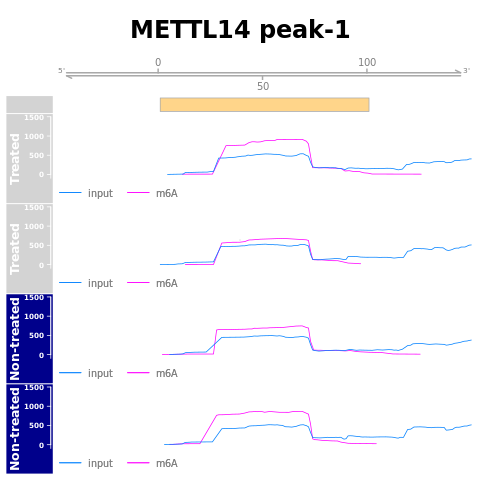

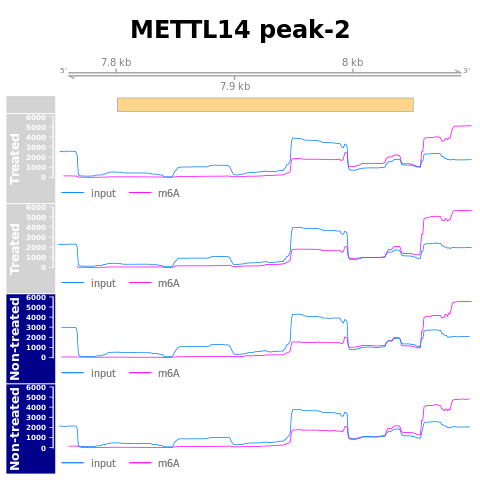

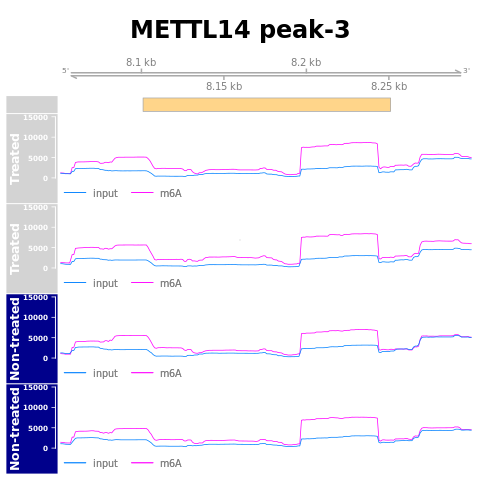

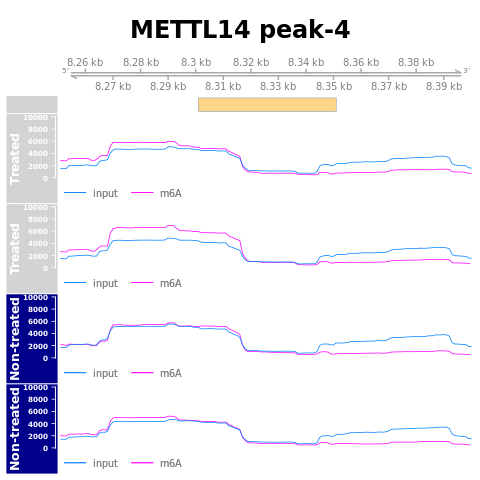

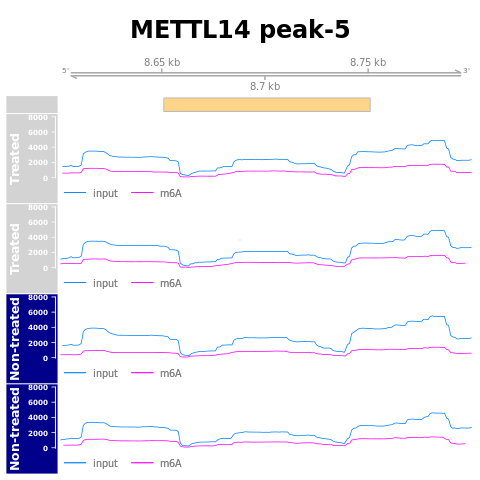

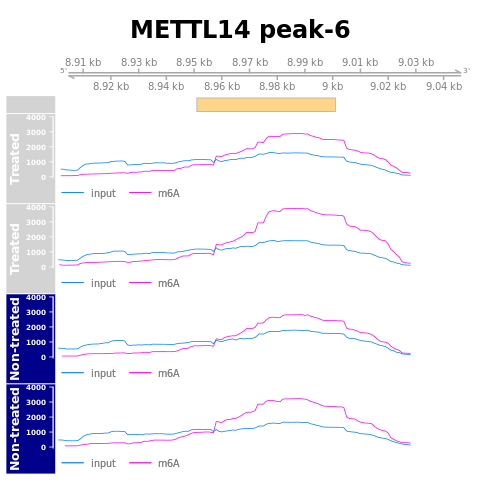

In [271]:
%%R
treat = 'METTL14'
ymax = c(1.5e3,6e3,1.5e4,1e4,8e3,4e3)
peak_ploter (treat,ymax)

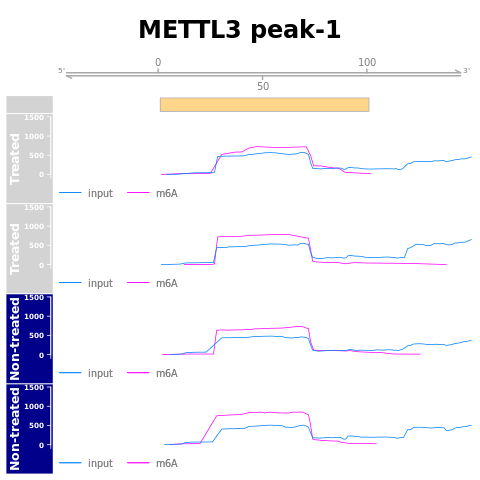

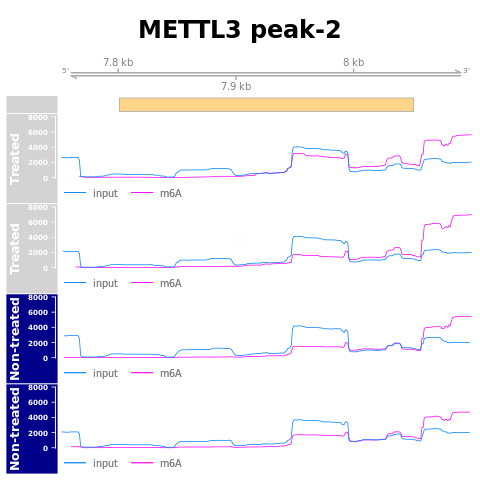

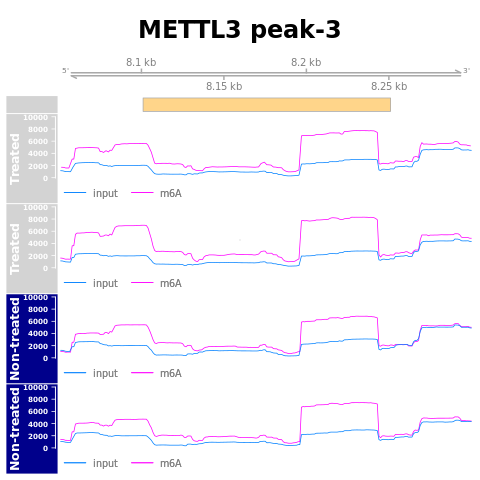

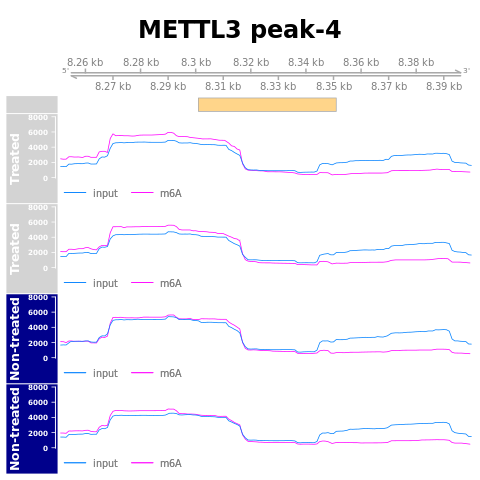

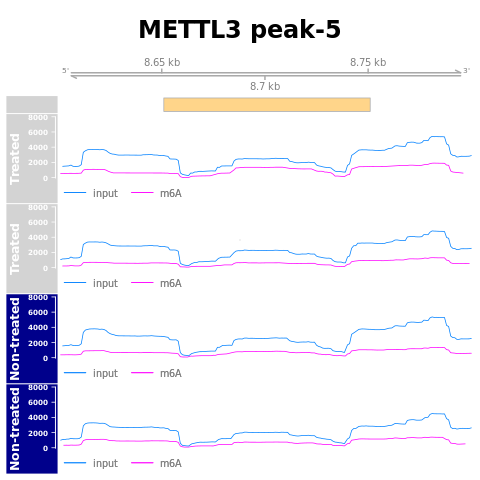

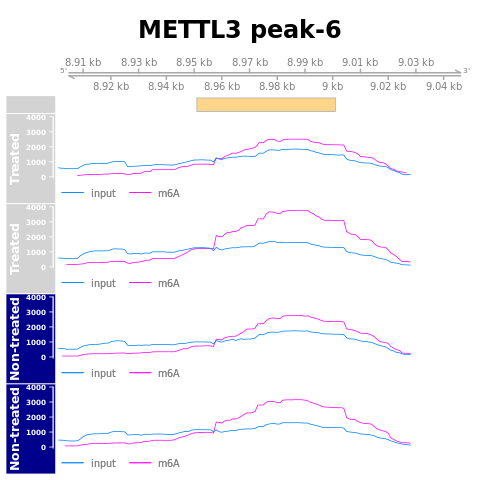

In [272]:
%%R
treat = 'METTL3'
ymax = c(1.5e3,8e3,1e4,8e3,8e3,4e3)
peak_ploter (treat,ymax)

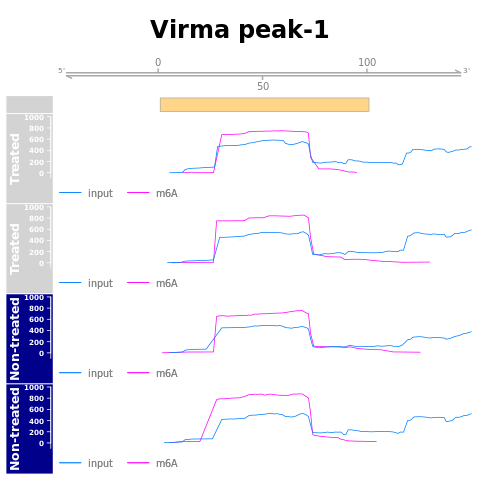

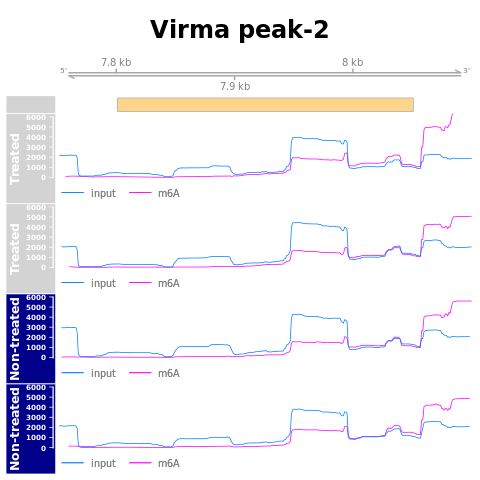

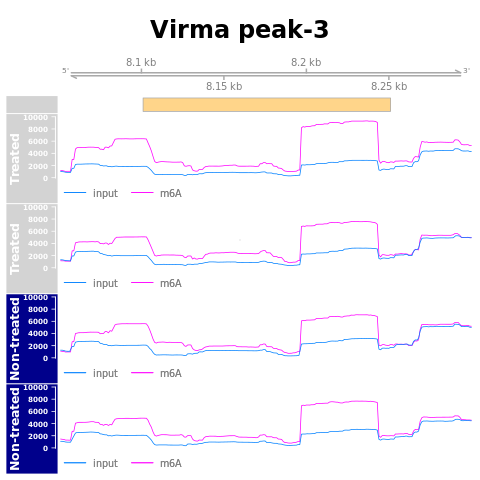

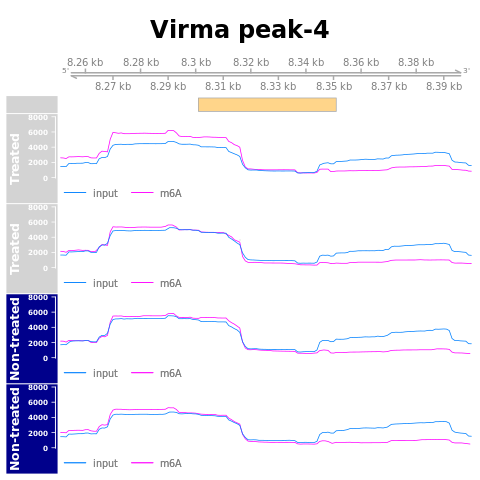

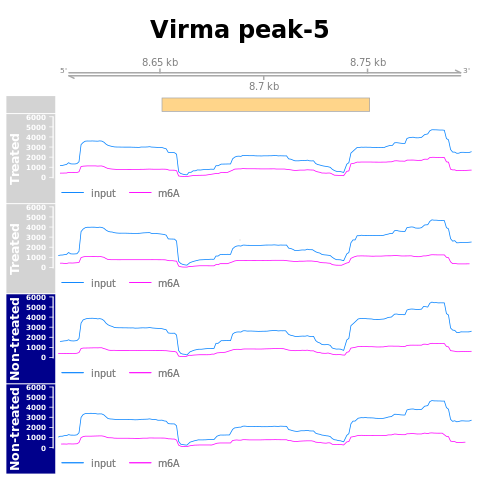

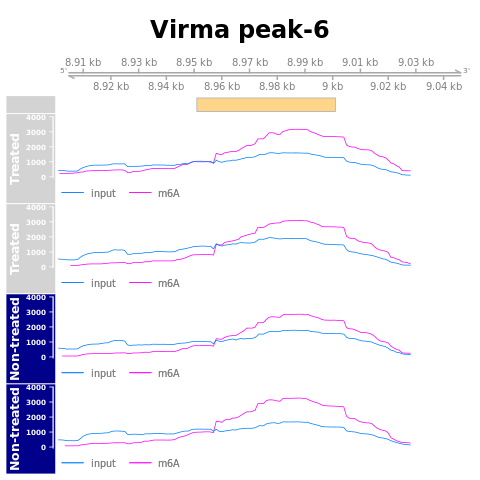

In [273]:
%%R
treat = 'Virma'
ymax = c(1e3,6e3,1e4,8e3,6e3,4e3)
peak_ploter (treat,ymax)

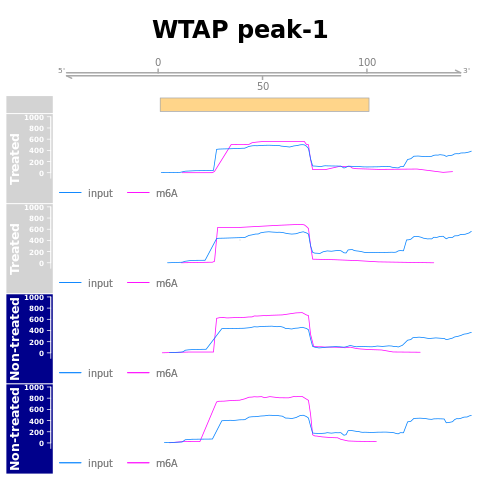

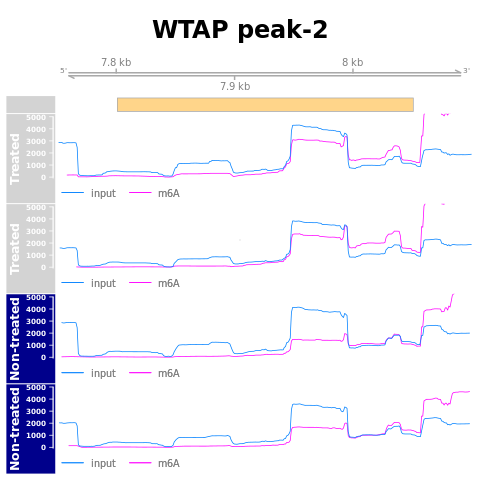

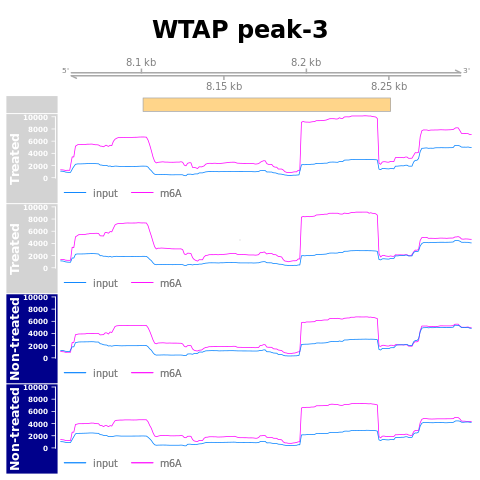

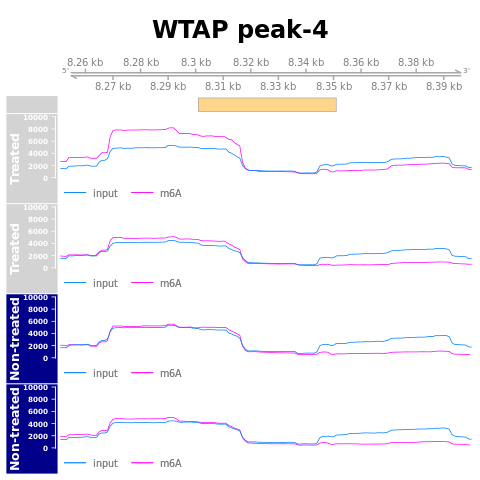

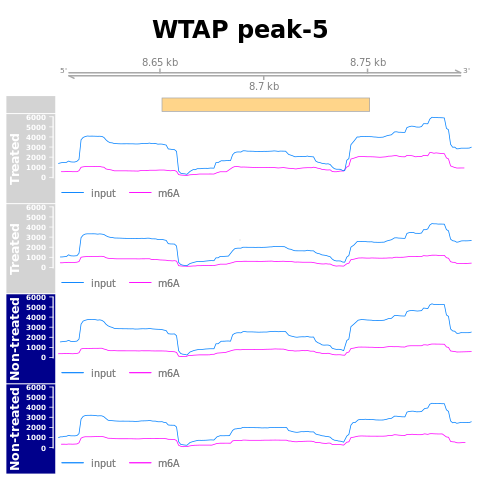

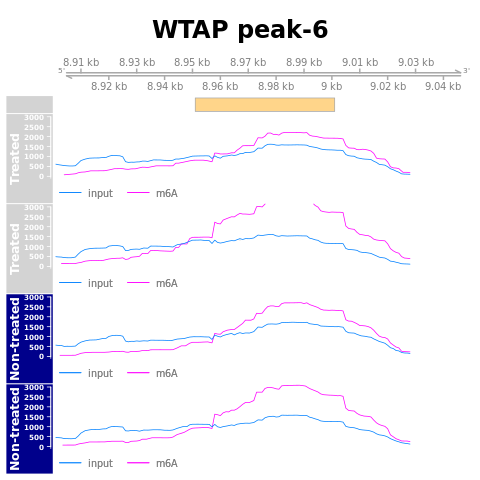

In [274]:
%%R
treat = 'WTAP'
ymax = c(1e3,5e3,1e4,1e4,6e3,3e3)
peak_ploter (treat,ymax)

## Similar paper 
> [Dynamics of the human and viral m6 A RNA methylomes during HIV-1 infection of T cells](https://www.nature.com/articles/nmicrobiol201611.pdf?proof=t)
[GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74016)

They’re using [pLAI.2 HIV](https://aidsreagent.org/reagentdetail.cfm?t=molecular_clones&id=47) but Judd have used [HIV-1 IIIB Virus](https://aidsreagent.org/reagentdetail.cfm?t=viruses&id=607)

Data in this paper might be useful to compare it with Judd’s data. They have used different pipelines to analyze data at that time. I'm downloading data using [SRA Toolkit](https://www.ncbi.nlm.nih.gov/sra/docs/sradownload/#download-sequence-data-files-usi)


https://trace.ncbi.nlm.nih.gov/Traces/sra/?study=SRP064809

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
mkdir peer/bam
for f in peer/fastq/*;do
    out=${f/fastq/bam};
    echo STAR --outSAMtype BAM SortedByCoordinate --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out.bam --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/

In [50]:
# sessionInfo()